In [2]:
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, binned_statistic_dd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
file = "../data/SSCURVES.xlsx"

In [4]:
def logistic(x, a, k, xc):
    return a/(1 + np.exp(-k*(x-xc)))

In [5]:
def r2_fn(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

In [6]:
def tsos(y):
    """Total sum of squares"""
    return np.sum((y-np.mean(y))**2)

def rsos(y, y_pred):
    """Residual sum of squares"""
    residuals = y - y_pred
    return np.sum(residuals**2)


def r_squared(y, y_pred):
    ss_tot = tsos(y)
    ss_res = rsos(y, y_pred)
    return 1 - ss_tot / ss_res

In [7]:
rs_results = []
def save_individual_fit(x, y, popt, sample_id, r2):
    y_pred = logistic(x, *popt)
    rs_results.append(r2)
    plt.figure(figsize=(3, 3), tight_layout=True)
    plt.plot(np.linspace(0, 2.5, 1000), logistic(np.linspace(0, 2.5, 1000), *popt), color='red', label="logistic fit")
    plt.scatter(x, y, marker='x', color='black', label="data")
    plt.xlabel("Stretch")
    plt.ylabel("Strain [MPa]")
    plt.title(f"Sample {sample_id}")
    plt.xlim([1, 1.6])
    plt.annotate(f"$R^2 = {r2:.4f}$", [0.4, 0.05], xycoords='axes fraction')
    if sample_id == 6:
        plt.legend(loc='center left')
    plt.savefig(f"outputs/compare_output/sample_{sample_id}.pdf")

In [29]:
sample_ids = np.array([51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 61, 61, 61])
outputs = np.array([[ 7.8789, 18.2500,  1.2910],
        [ 7.4570, 18.5625,  1.2627],
        [ 8.0078, 18.3125,  1.2832],
        [ 7.3672, 18.1875,  1.2793],
        [ 7.8555, 18.5625,  1.2861],
        [ 6.9570, 19.0781,  1.2568],
        [ 8.0312, 18.6094,  1.2803],
        [ 1.6924, 22.0625,  1.2373],
        [ 1.8340, 22.1094,  1.2500],
        [ 1.8291, 22.0938,  1.2705],
        [ 1.7559, 22.1406,  1.2129],
        [ 2.1777, 22.2344,  1.2432],
        [ 2.0801, 22.3281,  1.2188],
        [ 2.9980, 21.9844,  1.2354],
        [ 2.8848, 22.6562,  1.1943],
        [ 2.6758, 23.1406,  1.1973],
        [ 2.7031, 30.0781,  1.2773],
        [ 3.5801, 22.8438,  1.2041],
        [ 3.2715, 22.5312,  1.1973],
        [ 3.2461, 22.7344,  1.2314],
        [ 8.0000, 16.4219,  1.2334],
        [ 7.2734, 17.6719,  1.2363],
        [ 8.2422, 16.9844,  1.2363],
        [ 7.7695, 17.1719,  1.2432],
        [ 7.6055, 17.6719,  1.2334],
        [ 3.6875, 20.3281,  1.2031],
        [ 3.7812, 19.8906,  1.2139],
        [ 1.6650, 29.9062,  1.2549],
        [ 5.7227, 18.5156,  1.2588],
        [ 1.6484, 30.1562,  1.2676],
        [ 1.2500, 27.5312,  1.0820],
        [ 1.2285, 27.8125,  1.1104],
        [ 1.2988, 28.2031,  1.0996],
        [ 1.1768, 28.2188,  1.1250],
        [ 1.1025, 27.6562,  1.1064],
        [ 0.4397, 27.3281,  1.1279],
        [ 0.5840, 30.2812,  1.1553],
        [ 0.7881, 29.7812,  1.1201],
        [ 1.0303, 30.3594,  1.1387],
        [ 0.6704, 26.9688,  1.0967],
        [ 1.6738, 28.4375,  1.1289],
        [ 2.0508, 27.9375,  1.1504],
        [ 0.8843, 28.0625,  1.1523],
        [ 1.0361, 28.1094,  1.1465],
        [ 3.6777, 21.3750,  1.2344],
        [ 3.9512, 20.9375,  1.2334],
        [ 3.1445, 23.7344,  1.2744],
        [ 3.2363, 22.3906,  1.2061],
        [ 2.8574, 22.0156,  1.1641],
        [ 3.1465, 22.3594,  1.1943]])

 79%|██████████████████████████████████████████████████             | 50/63 [00:05<00:01,  8.82it/s]

[[ 7.8789 18.25    1.291 ]
 [ 7.457  18.5625  1.2627]
 [ 8.0078 18.3125  1.2832]
 [ 7.3672 18.1875  1.2793]
 [ 7.8555 18.5625  1.2861]
 [ 6.957  19.0781  1.2568]
 [ 8.0312 18.6094  1.2803]]


 81%|███████████████████████████████████████████████████            | 51/63 [00:07<00:05,  2.40it/s]

[[ 1.6924 22.0625  1.2373]
 [ 1.834  22.1094  1.25  ]
 [ 1.8291 22.0938  1.2705]
 [ 1.7559 22.1406  1.2129]
 [ 2.1777 22.2344  1.2432]
 [ 2.0801 22.3281  1.2188]
 [ 2.998  21.9844  1.2354]]


 83%|████████████████████████████████████████████████████           | 52/63 [00:09<00:07,  1.42it/s]

[[ 2.8848 22.6562  1.1943]
 [ 2.6758 23.1406  1.1973]]


 84%|█████████████████████████████████████████████████████          | 53/63 [00:10<00:06,  1.46it/s]

[[ 2.7031 30.0781  1.2773]
 [ 3.5801 22.8438  1.2041]
 [ 3.2715 22.5312  1.1973]
 [ 3.2461 22.7344  1.2314]]


/tmp/ipykernel_3183377/282009105.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3), tight_layout=True)
 86%|██████████████████████████████████████████████████████         | 54/63 [00:11<00:07,  1.17it/s]

[[ 8.     16.4219  1.2334]
 [ 7.2734 17.6719  1.2363]
 [ 8.2422 16.9844  1.2363]
 [ 7.7695 17.1719  1.2432]
 [ 7.6055 17.6719  1.2334]]


 87%|███████████████████████████████████████████████████████        | 55/63 [00:12<00:07,  1.02it/s]

[[ 3.6875 20.3281  1.2031]
 [ 3.7812 19.8906  1.2139]
 [ 1.665  29.9062  1.2549]
 [ 5.7227 18.5156  1.2588]
 [ 1.6484 30.1562  1.2676]]


 89%|████████████████████████████████████████████████████████       | 56/63 [00:14<00:07,  1.08s/it]

[[ 1.25   27.5312  1.082 ]
 [ 1.2285 27.8125  1.1104]
 [ 1.2988 28.2031  1.0996]
 [ 1.1768 28.2188  1.125 ]
 [ 1.1025 27.6562  1.1064]
 [ 0.4397 27.3281  1.1279]]


 90%|█████████████████████████████████████████████████████████      | 57/63 [00:15<00:07,  1.22s/it]

[[ 0.584  30.2812  1.1553]
 [ 0.7881 29.7812  1.1201]
 [ 1.0303 30.3594  1.1387]
 [ 0.6704 26.9688  1.0967]]


 92%|██████████████████████████████████████████████████████████     | 58/63 [00:16<00:05,  1.19s/it]

[[ 1.6738 28.4375  1.1289]
 [ 2.0508 27.9375  1.1504]
 [ 0.8843 28.0625  1.1523]
 [ 1.0361 28.1094  1.1465]]


 94%|███████████████████████████████████████████████████████████    | 59/63 [00:17<00:04,  1.18s/it]

[[ 3.6777 21.375   1.2344]
 [ 3.9512 20.9375  1.2334]
 [ 3.1445 23.7344  1.2744]]


 95%|████████████████████████████████████████████████████████████   | 60/63 [00:19<00:03,  1.16s/it]

[[ 3.2363 22.3906  1.2061]
 [ 2.8574 22.0156  1.1641]
 [ 3.1465 22.3594  1.1943]]


100%|███████████████████████████████████████████████████████████████| 63/63 [00:20<00:00,  3.12it/s]


No person id information found for 62
No person id information found for 555


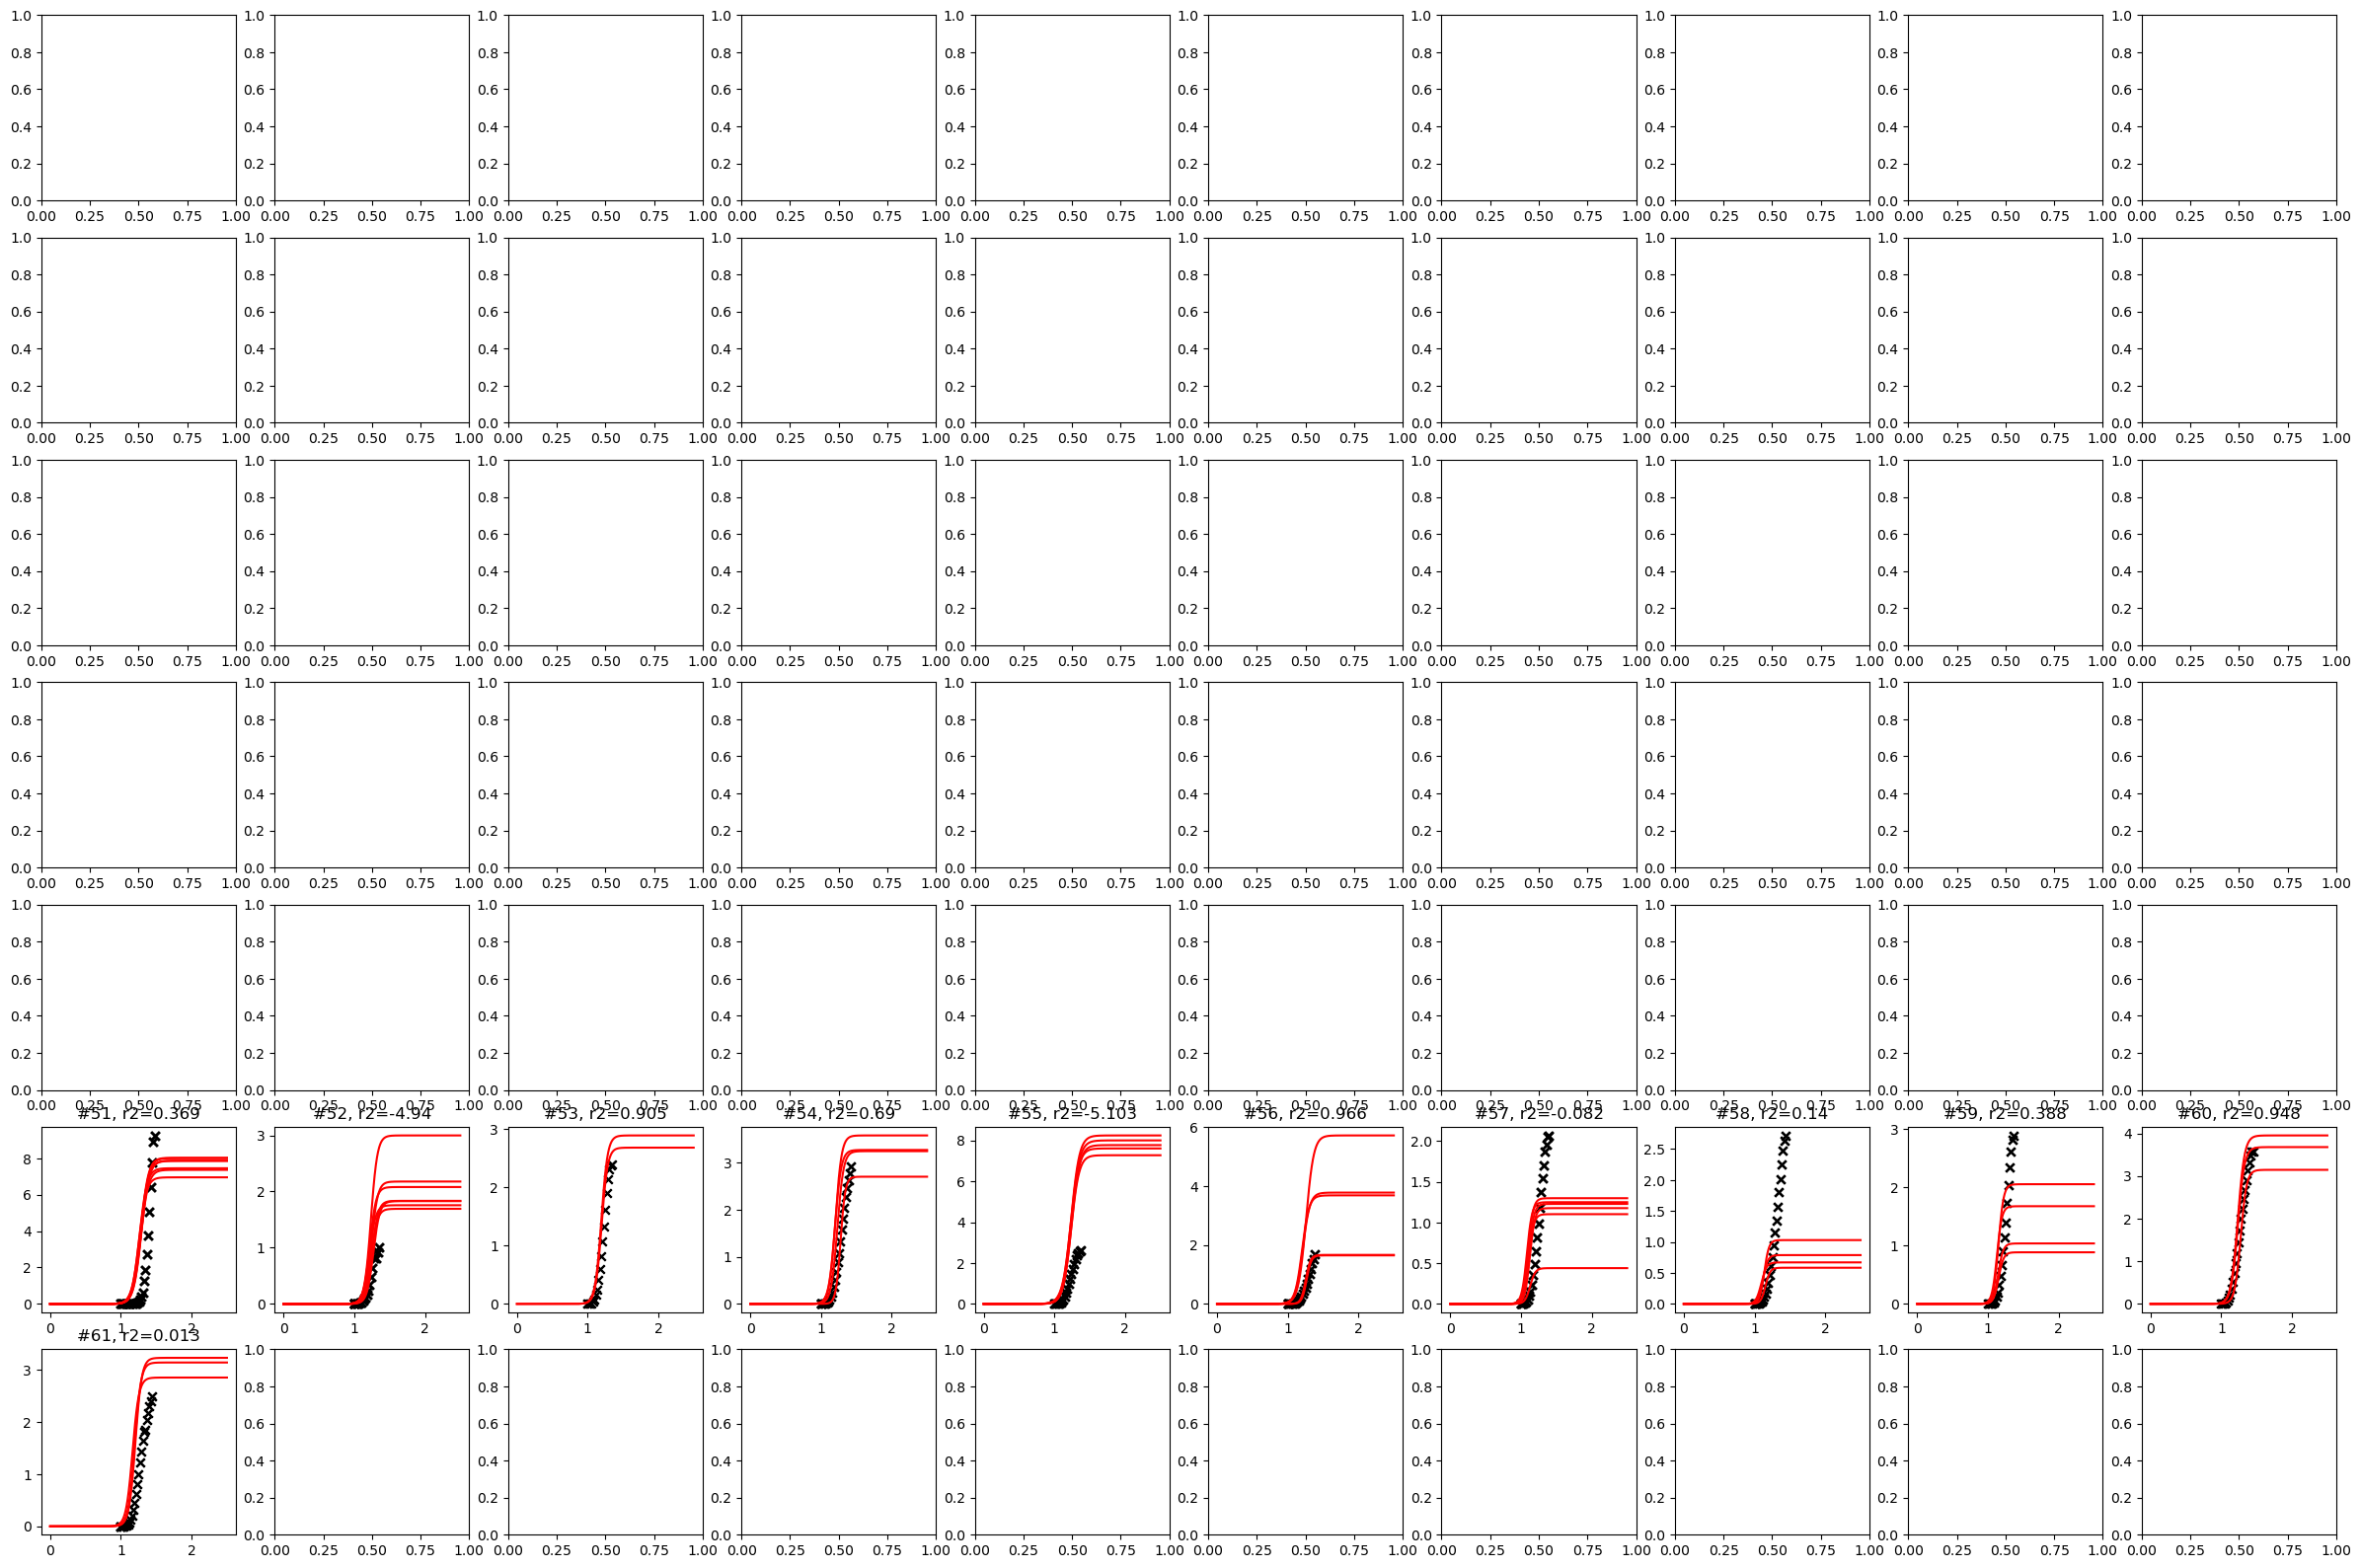

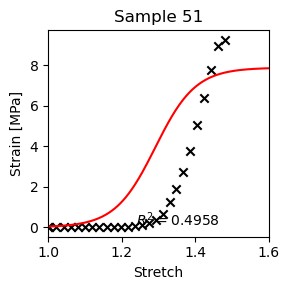

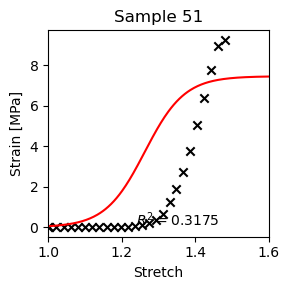

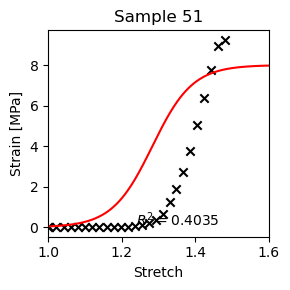

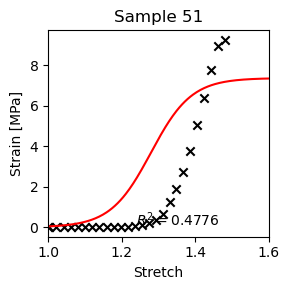

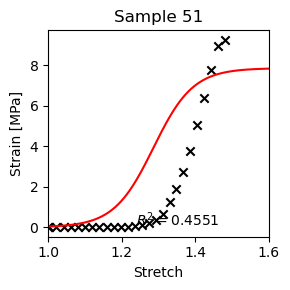

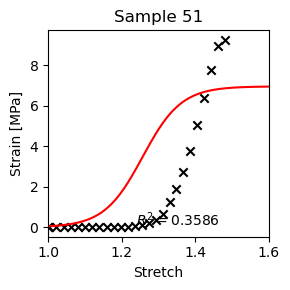

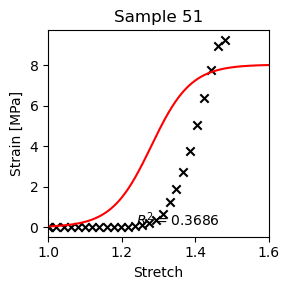

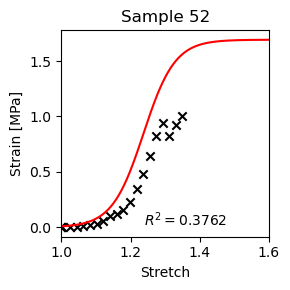

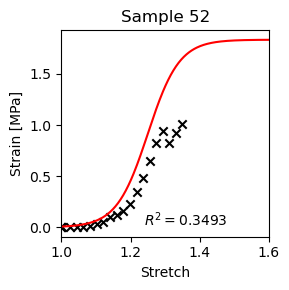

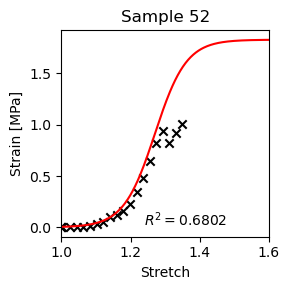

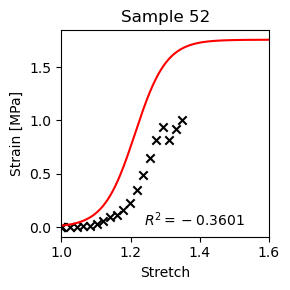

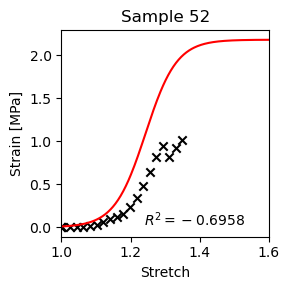

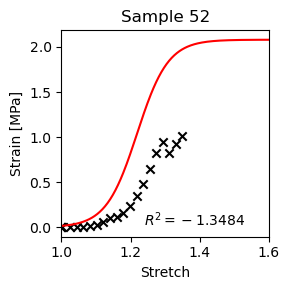

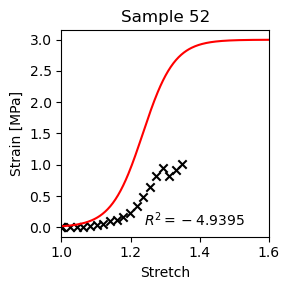

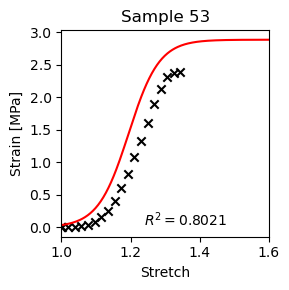

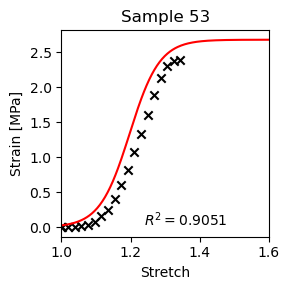

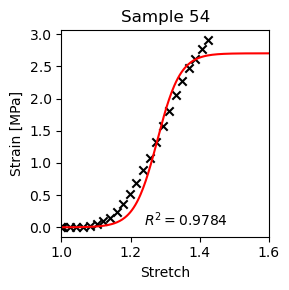

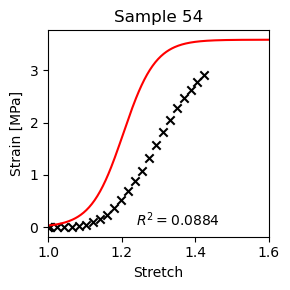

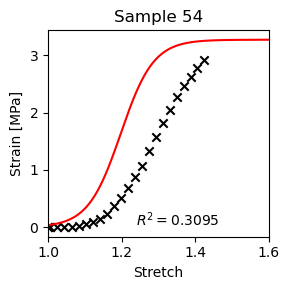

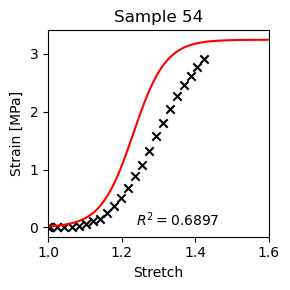

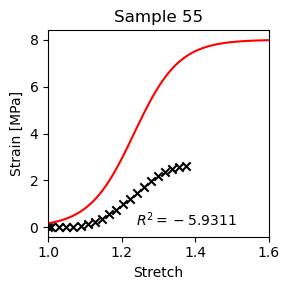

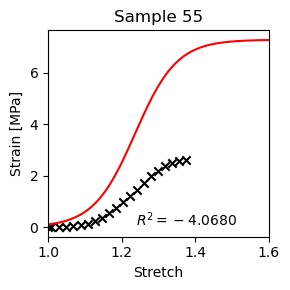

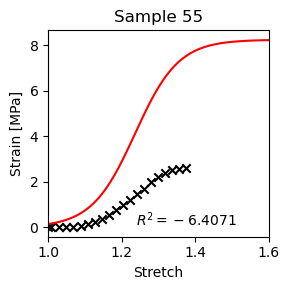

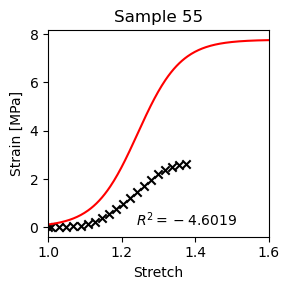

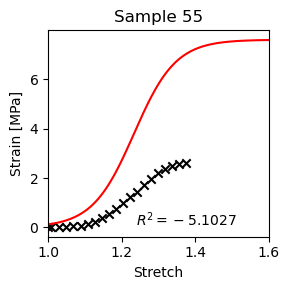

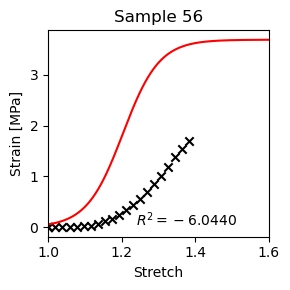

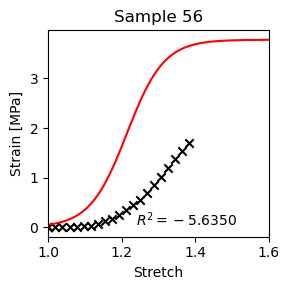

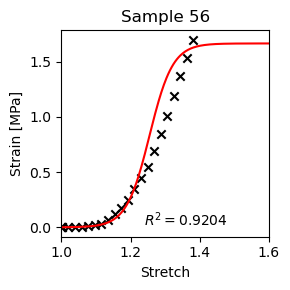

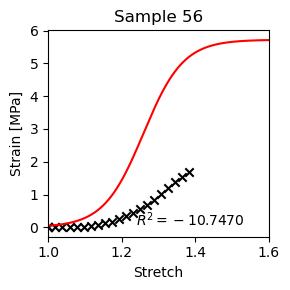

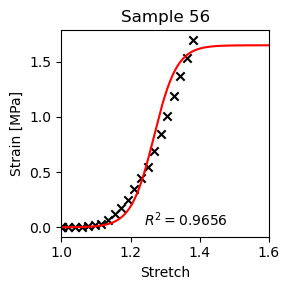

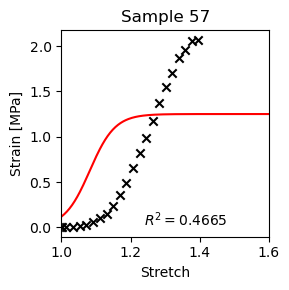

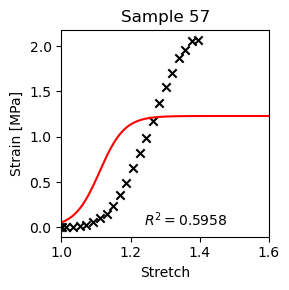

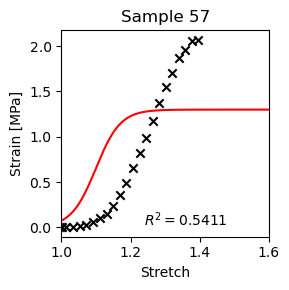

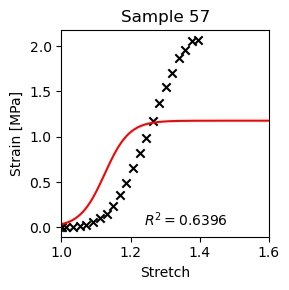

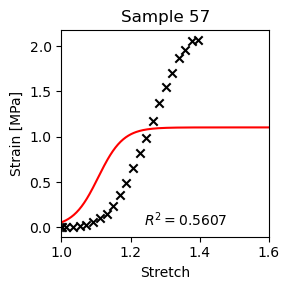

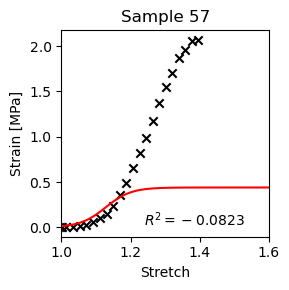

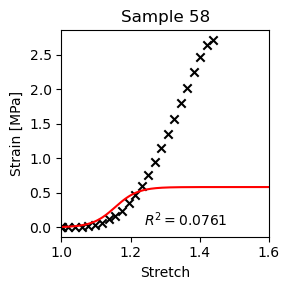

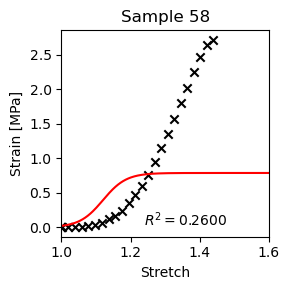

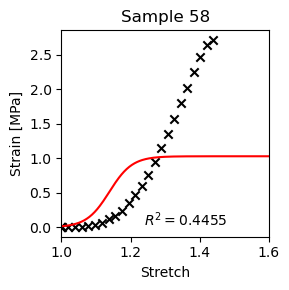

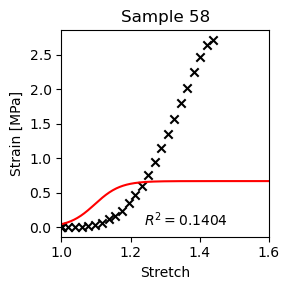

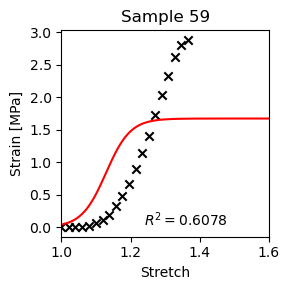

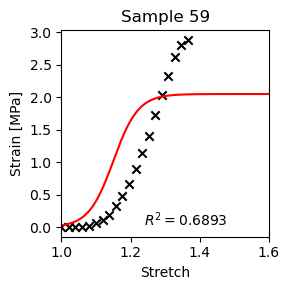

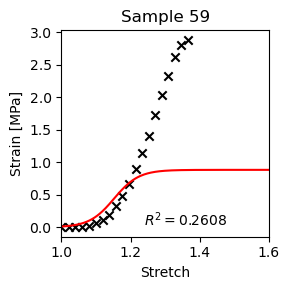

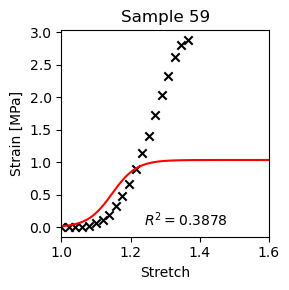

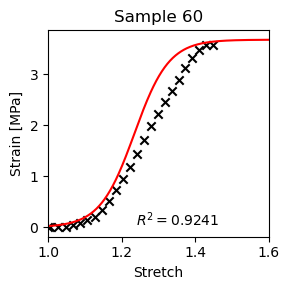

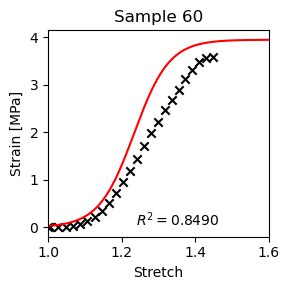

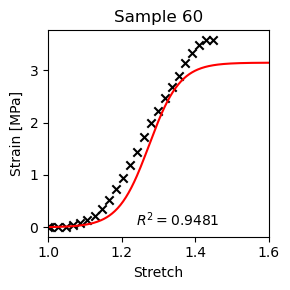

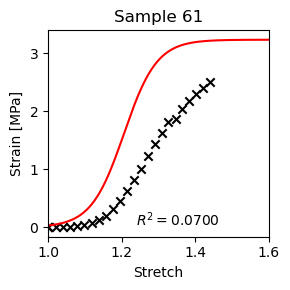

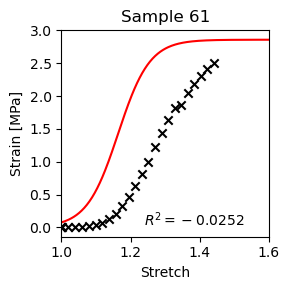

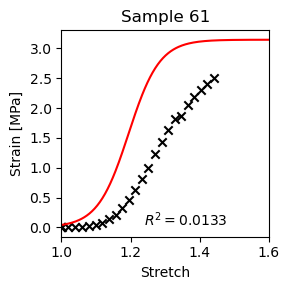

In [38]:
xls = pd.ExcelFile(file)

index_list =  []
person_ids = []
ages = []
sexes = []
a_list = []
k_list = []
xc_list = []

r2_list = []

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)
results = {}

for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)

    try:
        person_id = int(df['id'].iloc[0])
        type = str(df['type'].iloc[0])
        sex = str(df['sex'].iloc[0])
        age = str(df['age'].iloc[0])
    except KeyError:
        print(f"No person id information found for {sheet}")
        person_id = None
        continue

    if int(sheet) not in sample_ids:
        continue

    valid_type = 'thigh'
    if type != valid_type:
        tqdm.write(f"Only curves belonging to {valid_type} are included. Excluding person {person_id} (sheet {sheet})")
        continue

    
    results[int(sheet)] = outputs[np.argwhere(sample_ids == int(sheet))][:,0,:]
    print(results[int(sheet)])

    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    x_data = df['Strain']
    y_data = df['Stress']

    for result in results[int(sheet)]:
        r2 = r2_fn(y_data, logistic(x_data, *result))
        r2_list.append(r2)

        save_individual_fit(x_data, y_data, result, sheet, r2)

        ax.scatter(x_data, y_data, marker='x', color='black')
        ax.plot(x, logistic(x, *result), 'r-')
        ax.set_title(f"#{sheet}, r2={round(r2, 3)}")

plt.tight_layout()
plt.savefig("outputs/logistic_compare.png")
plt.show()
